In [11]:
# Imports
import numpy as np
import pandas as pd
from scipy import ndimage
import os

import matplotlib.pyplot as plt
import seaborn as sns

import imageio


from tensorflow.keras.applications.resnet50 import ResNet50
!pip install tensorflow
import tensorflow as tf
from tensorflow import keras

!pip install tensorflow_addons
import tensorflow_addons as tfa
from tensorflow.keras.applications.resnet50 import ResNet50
from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!pip install jupyter_http_over_ws
!jupyter serverextension enable --py jupyter_http_over_ws

Mounted at /content/drive
Traceback (most recent call last):
  File "/usr/local/bin/jupyter-serverextension", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python2.7/dist-packages/jupyter_core/application.py", line 267, in launch_instance
    return super(JupyterApp, cls).launch_instance(argv=argv, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/notebook/serverextensions.py", line 293, in start
    super(ServerExtensionApp, self).start()
  File "/usr/local/lib/python2.7/dist-packages/jupyter_core/application.py", line 256, in start
    self.subapp.start()
  File "/usr/local/lib/python2.7/dist-packages/notebook/serverextensions.py", line 210, in start
    self.toggle_server_extension_python(arg)
  File "/usr/local/lib/python2.7/dist-packages/notebook/serverextensions.py", line 199, in toggle_server_extension_python
    m, server_exts = 

# Loading data

In [12]:
# Loading data -- using data and methods from Kvammen et al.
#data = np.load('/content/drive/MyDrive/UCL/CDT_summer_project_2021/Kvammen2020_data_and_code/data.npz')

# loading data from my (Daniel's) Google drive dataset
file_path = '/content/drive/MyDrive/Sodankyla_database-20211027T162911Z-002/Codes/Kvammen_testing/data.npz'
data = np.load(file_path)

# Extracting the datasets
    # note the shape of each image indicates they have already been pre-processed
x_tr_kv = data['a'] # Training images. Numpy array of shape: (3000, 3, 128, 128)
y_tr_kv = data['b'] # Training labels. Numpy array of shape: (3000)
x_te_kv = data['c'] # Testing images. Numpy array of shape: (846, 3, 128, 128)
y_te_kv = data['d'] # Testing labels. Numpy array of shape: (846)


## reshaping the images for use in a CNN which expects RGB channels to be last 
x_tr_kv = np.moveaxis(x_tr_kv, 1, -1)
x_te_kv = np.moveaxis(x_te_kv, 1, -1)
#x_val = np.moveaxis(x_val, 1, -1)

# Definining the classes - each class corresponds to a label
classes = ['Arcs',
           'Breakup',
           'Colored',
           'Discrete',
           'Edge',
           'Faint',
           'Patchy']

Exception ignored in: <function NpzFile.__del__ at 0x7fe43cd74710>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py", line 223, in __del__
  File "/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py", line 218, in close
OSError: [Errno 107] Transport endpoint is not connected


In [10]:
# loading sodankyla images
file_path = 'C:/Users/user/Google Drive/UCL/CDT_summer_project_2021/Sodankyla_images/train_test_zipped/data_sodankyla.npz'

data_sd = np.load(file_path)

x_tr_sd = data_sd['a']
y_tr_sd = data_sd['b'] 
x_te_sd = data_sd['c']
y_te_sd = data_sd['d']

FileNotFoundError: ignored

In [13]:
def plot(img):
    '''Plots a single image'''
    plt.figure(figsize= (6,6))
    plt.imshow(img)
    plt.show()

def plot_wrong(x, y_label, y_pred, idx):
    '''Plots an image with its labels'''
    plt.figure(figsize= (8,8))
    img = x[idx]
    plt.imshow(img)
    plt.title('Label:{} | Pred:{}'.format( classes[y_label[idx]], classes[y_pred[idx]]))
    plt.show()

def conf_mat(y_true, y_pred, save_name = None): 
    # creating confusion matrix
    conf_mat_sd = tf.math.confusion_matrix(labels = y_true, predictions = y_pred).numpy()

    # converting to dataframe
    conf_mat_df = pd.DataFrame(conf_mat_sd,
                            index = classes,
                            columns = classes)

    conf_mat_norm = conf_mat_df.div(conf_mat_df.sum(axis=1), axis=0) # normalized confusion matrix

    # plotting the confusion matrix
    plt.figure(figsize=(8, 8))
    sns.heatmap(conf_mat_norm, annot=True,cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout() 
    if save_name != None:
        plt.savefig( 'figures/'+ save_name)
    plt.show()
    

# Training CNN on Kvammen dataset 

In [14]:
# testing the ResNet50 function in tensorflow

resnet_import = ResNet50(include_top = False, weights = None, input_shape = (128, 128, 3))  # include_top removes the last dense layer

# reducing the dimensions of the resnet output and adding a final output dense layer
resnet = tf.keras.Sequential([
    resnet_import,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(7, activation='softmax')
])
l_rate = 1e-5
# not sure if the crossentropy applies softmax or just works with unormalized logits
resnet.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), optimizer = keras.optimizers.Adam(learning_rate= l_rate), metrics = 'accuracy') 

In [15]:
# using same training regime as in the example resnet-18 notebook from Kvammen et al.
res_hist = resnet.fit(x_tr_kv, y_tr_kv, epochs = 100, batch_size = 32, validation_data = (x_te_kv, y_te_kv)) # used batch size which is a power of 2 a suits better the physical architecture of GPU, doesnt seem to be faster than batchsize 100

Epoch 1/100
94/94 [==============================] - 55s 318ms/step - loss: 1.2554 - accuracy: 0.5727 - val_loss: 1.7561 - val_accuracy: 0.5426
Epoch 2/100
94/94 [==============================] - 27s 287ms/step - loss: 0.8292 - accuracy: 0.7153 - val_loss: 1.6342 - val_accuracy: 0.5426
Epoch 3/100
94/94 [==============================] - 27s 283ms/step - loss: 0.6921 - accuracy: 0.7657 - val_loss: 1.5914 - val_accuracy: 0.5426
Epoch 4/100
94/94 [==============================] - 27s 285ms/step - loss: 0.6096 - accuracy: 0.8020 - val_loss: 2.1504 - val_accuracy: 0.5426
Epoch 5/100
94/94 [==============================] - 27s 283ms/step - loss: 0.5577 - accuracy: 0.8160 - val_loss: 1.9897 - val_accuracy: 0.5426
Epoch 6/100
94/94 [==============================] - 27s 283ms/step - loss: 0.5015 - accuracy: 0.8347 - val_loss: 2.1378 - val_accuracy: 0.5473
Epoch 7/100
94/94 [==============================] - 27s 283ms/step - loss: 0.4734 - accuracy: 0.8453 - val_loss: 2.0560 - val_accuracy:

 Accuracy of this CNN trained and evaluated on Kvammen dataset climbs up to 94%. Trained on the entire training dataset, test set used as validation set (trained on the entire original train set).  

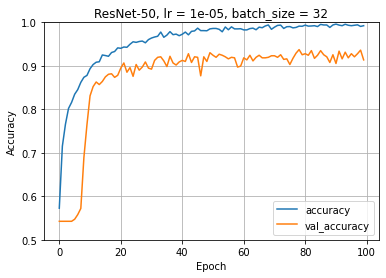

In [16]:
# plotting a single resnet 2 training progress
plt.figure()
plt.plot(res_hist.history['accuracy'], label='accuracy')
plt.plot(res_hist.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.grid()
plt.legend(loc='lower right')
plt.title('ResNet-50, lr = {:.0e}, batch_size = {}'.format(l_rate,32))
plt.show()
#plt.savefig('accuracy_epochs_lr{:.0e}_bs32.png'.format(l_rate))

In [18]:
#Saving the model

modelname = "ModelKVe100"
resnet.save("/content/drive/MyDrive/Sodankyla_database-20211027T162911Z-002/Codes/Kvammen_testing/Trained Models/" + modelname)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Sodankyla_database-20211027T162911Z-002/Codes/Kvammen_testing/Trained Models/ModelKVe100/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


# Accuracy on Sodankyla

In [ ]:
accu_sodankyla = resnet.evaluate(x_tr_sd, y_tr_sd)

NameError: ignored

CNN trained on Kvammen and tested on Sodankyla train set does not perform very well, usually remains within the 38-45% range

## Confusion matrix

In [ ]:
# predictions on the test set
y_pred = resnet.predict_classes(x_tr_sd)
print(y_pred)

C:\Users\user\anaconda3\envs\aurora\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[2 2 6 ... 6 6 6]


In [ ]:
# creating confusion matrix
conf_mat = tf.math.confusion_matrix(labels = y_tr_sd, predictions = y_pred).numpy()

# converting to dataframe
conf_mat_df = pd.DataFrame(conf_mat,
                           index = classes,
                           columns = classes)
print(conf_mat_df)

          Arcs  Breakup  Colored  Discrete  Edge  Faint  Patchy
Arcs        26       50      292         5     0      1      70
Breakup      3      442      426         2     1      0      22
Colored      6       58      358         9     0      8      34
Discrete     4       12       38        11     0      0      20
Edge         0        0       41         3    16     35      26
Faint        1        0       30         3     0     63       8
Patchy       1       37      578         3     1      0     228


## Mislabelled images

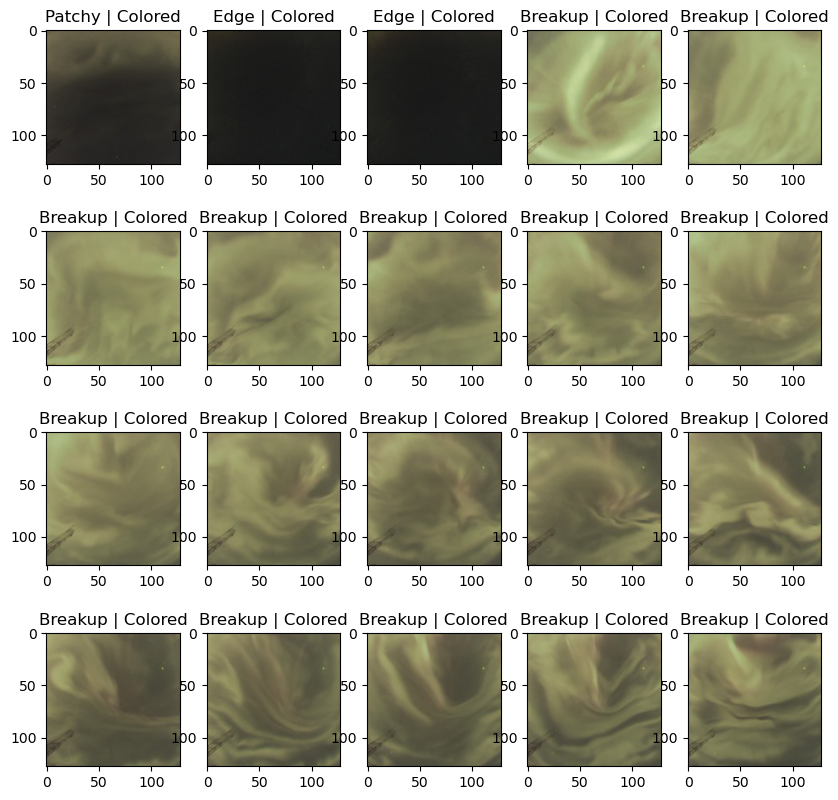

In [ ]:
# dispalying mislabelled images
mislabel_indices = np.where(y_tr_sd != y_pred )[0]

skip = 0

plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.grid(False)
    idx = mislabel_indices[i+skip]
    plt.imshow(x_tr_sd[idx], cmap=plt.cm.binary)
    plt.title('{} | {}'.format( classes[y_tr_sd[idx]], classes[y_pred[idx]]))
    
plt.show()

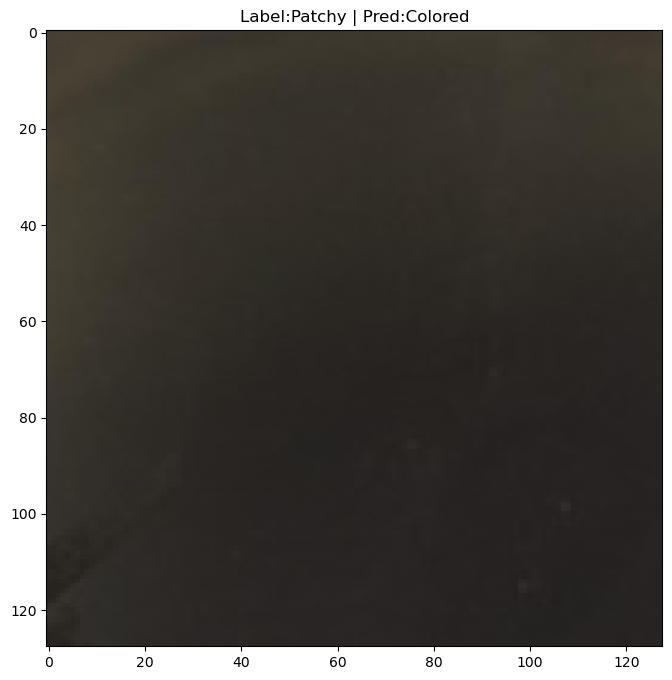

In [ ]:
plot_wrong(x_tr_sd, y_tr_sd, y_pred ,mislabel_indices[50])

# Resnet trained and tested on Sodankyla images

In [ ]:
# create model
resnet_sd = keras.Sequential([
    keras.models.clone_model(resnet_import),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(7, activation='softmax')
])

# compile
resnet_sd.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), optimizer = keras.optimizers.Adam(learning_rate= l_rate), metrics = 'accuracy') 

In [ ]:
# training on Sodankyla images
res_hist_sd = resnet_sd.fit(x_tr_sd, y_tr_sd, epochs = 200, batch_size = 32, validation_data = (x_te_sd, y_te_sd)) # used batch size which is a power of 2 a suits better the physical architecture of GPU, doesnt seem to be faster than batchsize 100

Epoch 1/200
93/93 [==============================] - 23s 154ms/step - loss: 2.2175 - accuracy: 0.3456 - val_loss: 2.7312 - val_accuracy: 0.2838
Epoch 2/200
93/93 [==============================] - 12s 134ms/step - loss: 1.2287 - accuracy: 0.5481 - val_loss: 3.5247 - val_accuracy: 0.2838
Epoch 3/200
93/93 [==============================] - 13s 137ms/step - loss: 1.0852 - accuracy: 0.5855 - val_loss: 4.2822 - val_accuracy: 0.2838
Epoch 4/200
93/93 [==============================] - 12s 134ms/step - loss: 1.0165 - accuracy: 0.6144 - val_loss: 4.0066 - val_accuracy: 0.2838
Epoch 5/200
93/93 [==============================] - 12s 128ms/step - loss: 0.9507 - accuracy: 0.6464 - val_loss: 3.4718 - val_accuracy: 0.2865
Epoch 6/200
93/93 [==============================] - 12s 125ms/step - loss: 0.9261 - accuracy: 0.6487 - val_loss: 2.7382 - val_accuracy: 0.3039
Epoch 7/200
93/93 [==============================] - 12s 125ms/step - loss: 0.8930 - accuracy: 0.6568 - val_loss: 2.1724 - val_accuracy:

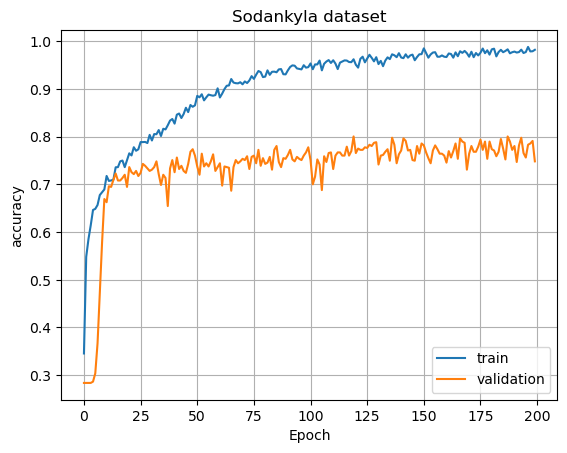

In [ ]:
plt.figure()
plt.plot(res_hist_sd.history['accuracy'], label='train')
plt.plot(res_hist_sd.history['val_accuracy'], label = 'validation')

plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Sodankyla dataset')
#plt.ylim([0.5, 1])
plt.grid()
plt.legend(loc='lower right')
plt.savefig('figures/Sodankyla_train_history')
plt.show()

Single CNN trained and tested on Sodankyla images has validation accuracies that range from 76-78% when trained for 200 epochs.

C:\Users\user\anaconda3\envs\aurora\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


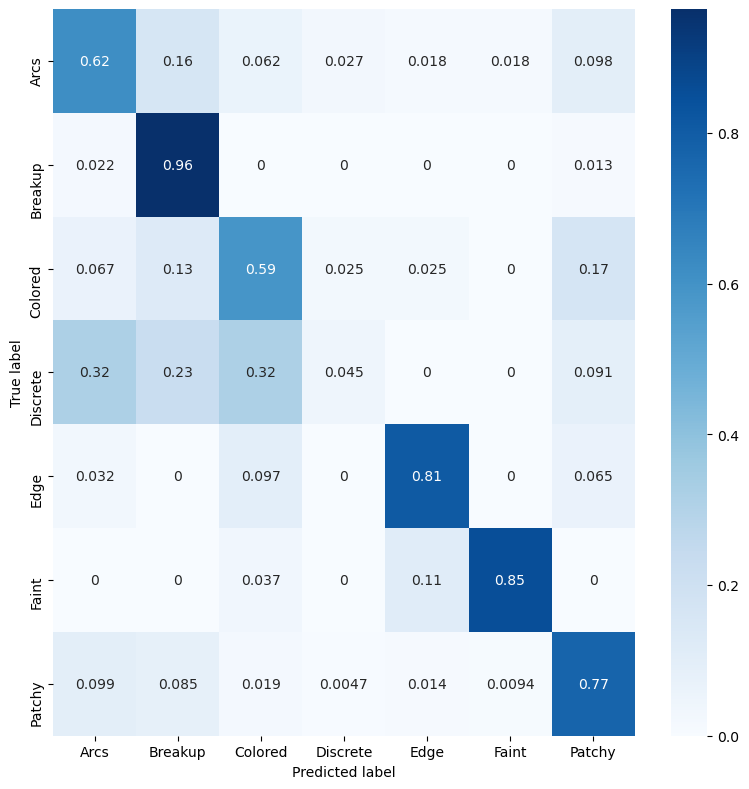

In [ ]:
y_pred_sd = resnet_sd.predict_classes(x_te_sd)
conf_mat(y_te_sd, y_pred_sd)

In [ ]:
# accuracy on the Kvammen dataset
print('CNN accuracy trained on Sodankyla and tested on Kvammen/n', resnet_sd.evaluate(x_tr_kv, y_tr_kv)[-1])

94/94 [==============================] - 4s 40ms/step - loss: 1.5872 - accuracy: 0.6907
CNN accuracy trained on Sodankyla and tested on Kvammen/n 0.690666675567627


CNN trained on Sodankyla and tested on Kvammen data seems to do much better than the other way around. The accuracy maxed at 71% once, nevertheless this is just a single number which might be very misleading. Kvammen dataset has a lot of patchy images which our network might be good at identifying which would push the accuracy much higher. Carefull inspection would be required to have a better understanding of this result.

## Mislabelled images - Sodankyla

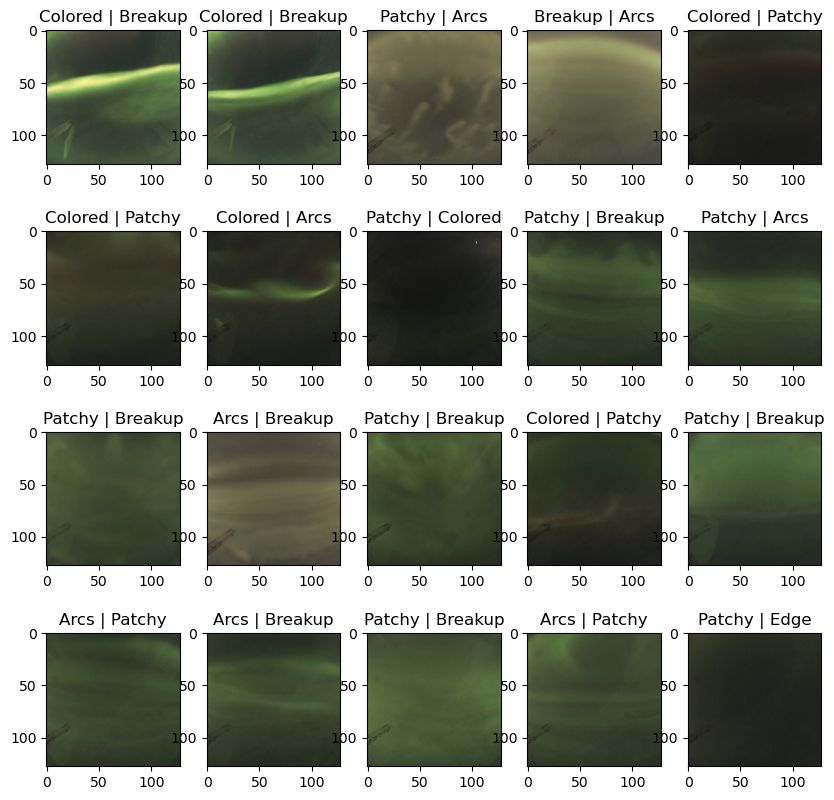

In [ ]:
# dispalying mislabelled images
mislabel_indices_sd = np.where(y_te_sd != y_pred_sd )[0]

skip = 40

plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.grid(False)
    idx = mislabel_indices_sd[i+skip]
    plt.imshow(x_te_sd[idx], cmap=plt.cm.binary)
    plt.title('{} | {}'.format( classes[y_te_sd[idx]], classes[y_pred_sd[idx]]))

plt.show()

# Commonly mislabelled images
Plotting a figure to be shown in the final report

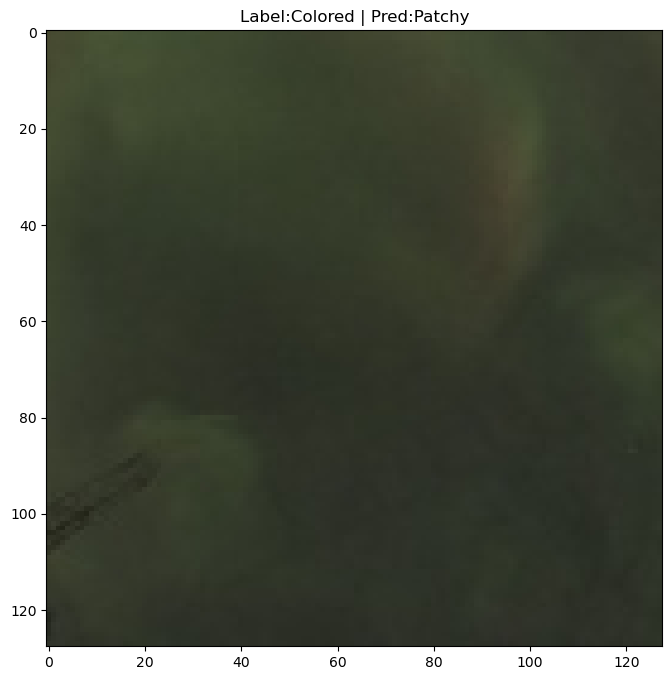

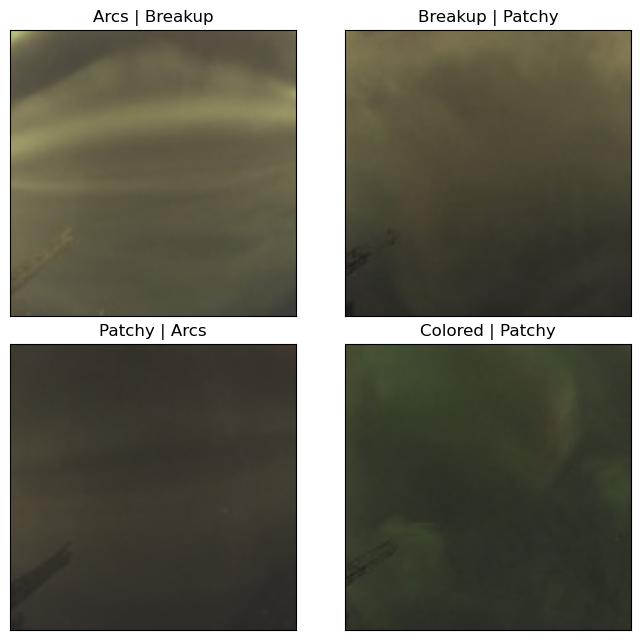

In [ ]:
plot_indx = [8,11,18,32]

plot_wrong(x_te_sd, y_te_sd, y_pred_sd, mislabel_indices_sd[32])

plt.figure(figsize=(8,8))
for i in range(4):
    plt.subplot(2,2, i+1)
    plt.grid(False)
    idx = mislabel_indices_sd[plot_indx[i]]
    plt.imshow(x_te_sd[idx], cmap=plt.cm.binary)
    plt.title('{} | {}'.format( classes[y_te_sd[idx]], classes[y_pred_sd[idx]]))

    # removing ticks
    plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)

plt.subplots_adjust(left=0.1,
                    bottom=0.05, 
                    right=0.9, 
                    top=0.8, 
                    wspace=0.1, 
                    hspace=0.1)
plt.savefig('figures/example_mislabelled')
plt.show()

idx: 0


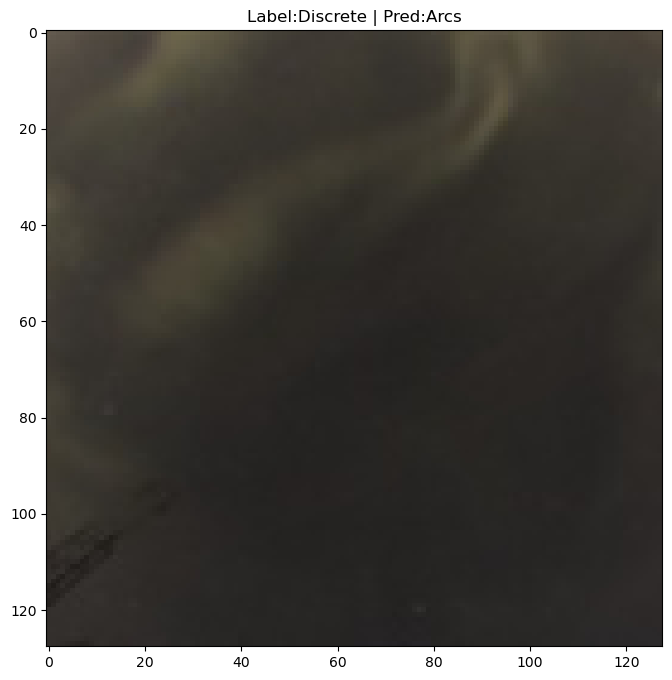

desktop.ini


In [ ]:
img_file_names = os.listdir('C:/Users/user/Google Drive/UCL/CDT_summer_project_2021/Sodankyla_images/' +'test_set')
idx = 0
print('idx:', mislabel_indices_sd[idx])
plot_wrong(x_te_sd, y_te_sd, y_pred_sd, mislabel_indices_sd[idx])
print(img_file_names[mislabel_indices_sd[idx]])

# Combined dataset

In [ ]:
x_tr = np.concatenate((x_tr_kv, x_tr_sd))
y_tr = np.concatenate((y_tr_kv, y_tr_sd))
x_te = np.concatenate((x_te_kv, x_te_sd))
y_te = np.concatenate((y_te_kv, y_te_sd))

In [ ]:
# create model
resnet_comb = keras.Sequential([
    keras.models.clone_model(resnet_import),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(7, activation='softmax')
])
# compile
resnet_comb.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), optimizer = keras.optimizers.Adam(learning_rate= l_rate), metrics = 'accuracy') 

In [ ]:
# training on combined images
res_hist_comb = resnet_comb.fit(x_tr, y_tr, epochs = 100, batch_size = 32, validation_data = (x_te, y_te)) 

Epoch 1/100
193/193 [==============================] - 30s 137ms/step - loss: 1.2854 - accuracy: 0.5394 - val_loss: 2.3670 - val_accuracy: 0.4175
Epoch 2/100
193/193 [==============================] - 25s 129ms/step - loss: 0.9773 - accuracy: 0.6476 - val_loss: 3.1316 - val_accuracy: 0.4175
Epoch 3/100
193/193 [==============================] - 25s 129ms/step - loss: 0.9085 - accuracy: 0.6722 - val_loss: 1.8443 - val_accuracy: 0.4729
Epoch 4/100
193/193 [==============================] - 25s 128ms/step - loss: 0.8254 - accuracy: 0.6939 - val_loss: 1.2874 - val_accuracy: 0.5630
Epoch 5/100
193/193 [==============================] - 25s 130ms/step - loss: 0.7928 - accuracy: 0.7127 - val_loss: 0.8402 - val_accuracy: 0.6859
Epoch 6/100
193/193 [==============================] - 25s 130ms/step - loss: 0.7755 - accuracy: 0.7208 - val_loss: 0.8161 - val_accuracy: 0.7182
Epoch 7/100
193/193 [==============================] - 25s 130ms/step - loss: 0.7570 - accuracy: 0.7239 - val_loss: 0.7745 -

# Top 2 accuracy

In [ ]:
def top2_accuracy(model, x, y):
    '''Calculates the top 2 accuracy of the model, which means that if either of the
    two highest probability predicted class is the correct label, the classification 
    counts as correct'''
    y_probs = model.predict(x, batch_size = 32)
    y_2top = np.argpartition(y_probs, -2, axis=-1) # index class predictions are sorted

    n_correct = 0
    # for each prediction
    for i, indices in enumerate(y_2top):
        # if the label is any of the top 2 predictions, count as correct
        if y[i] in indices[-2:]:
            n_correct += 1

    print('Top 2 accuracy: {:1.1f} %'.format(n_correct/len(x)*100))

In [ ]:
print('Sodankyla')
top2_accuracy(resnet_sd, x_te_sd, y_te_sd)
print('\nKvammen')
top2_accuracy(resnet, x_te_kv, y_te_kv)

Sodankyla
Top 2 accuracy: 92.6 %

Kvammen
Top 2 accuracy: 98.6 %


# Ensemble learning 

Ensemble learning proved to boost the networks performance.\
number of networks : accuracy \
    1 : 76-78 % \
    5 :  79   %   # tested once \
    9 :  81   % 

In [ ]:
models = []

# creates and compiles the model
for i in range(9):
    # create model
    models.append( keras.Sequential([
                        keras.models.clone_model(resnet_import),
                        tf.keras.layers.GlobalAveragePooling2D(),
                        tf.keras.layers.Dense(7, activation='softmax')
                    ])  )
    # compile
    models[i].compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), optimizer = keras.optimizers.Adam(learning_rate= l_rate), metrics = 'accuracy') 


In [ ]:
# training CNNs
for model in models:
    model.fit(x_tr_sd, y_tr_sd, epochs = 100, batch_size = 32, validation_data = (x_te_sd, y_te_sd)) 

Epoch 1/100
93/93 [==============================] - 17s 139ms/step - loss: 1.5047 - accuracy: 0.4872 - val_loss: 2.2150 - val_accuracy: 0.2838
Epoch 2/100
93/93 [==============================] - 12s 130ms/step - loss: 1.1533 - accuracy: 0.5713 - val_loss: 2.8208 - val_accuracy: 0.2838
Epoch 3/100
93/93 [==============================] - 12s 128ms/step - loss: 1.0649 - accuracy: 0.5878 - val_loss: 3.3528 - val_accuracy: 0.2838
Epoch 4/100
93/93 [==============================] - 12s 131ms/step - loss: 1.0228 - accuracy: 0.6006 - val_loss: 3.3654 - val_accuracy: 0.2838
Epoch 5/100
93/93 [==============================] - 12s 128ms/step - loss: 0.9539 - accuracy: 0.6295 - val_loss: 2.7637 - val_accuracy: 0.2865
Epoch 6/100
93/93 [==============================] - 12s 134ms/step - loss: 0.9234 - accuracy: 0.6339 - val_loss: 2.1927 - val_accuracy: 0.3213
Epoch 7/100
93/93 [==============================] - 12s 134ms/step - loss: 0.9067 - accuracy: 0.6467 - val_loss: 1.8360 - val_accuracy:

In [ ]:
def max_vote(models, X, y_true):
    '''Simple function that implements the max voting ensemble technique,
    democratic vote between the members of models'''

    y_preds = np.empty(shape = (len(models), len(X)) ) # class predictions from all models, arrays of 7 probabilities for each class

    for i, model in enumerate(models):
        y_preds[i] = np.argmax(model.predict(X, batch_size = 32) ,axis=1) # selects the class with highest probability

    y_preds = np.transpose(y_preds) # transpose the array so the 5 predictions for each image are grouped
    
    # counts the most occured element and returns it, if there are two returns the first encountered (I think)
    ensemble_pred = [np.argmax( np.bincount(y_preds[i].astype('int32'))) for i in range(len(y_preds))] 

    # compares the ensemble predictions with true labels, arraye of len(y_true) containing either True or False
    correct = ensemble_pred == y_true

    return ensemble_pred, np.sum(correct)/y_true.shape[0]  # returns accuracy

ensemble_pred, accu_ensemble = max_vote(models, x_te_sd, y_te_sd) 

In [ ]:
print('Ensmeble accuracy of 9 models\n', '{:1.1f} %'.format(accu_ensemble*100))

Ensmeble accuracy of 9 models
 81.5 %


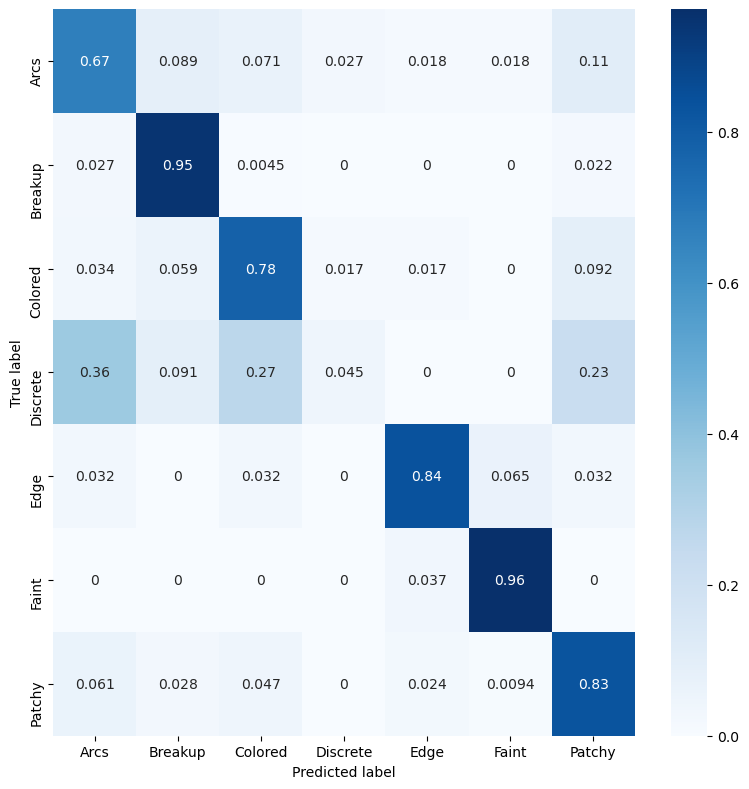

In [ ]:
conf_mat(y_te_sd, ensemble_pred, 'Sodankyla_train_test_ensemble9')